## Feedback Prize - English Language Learning with Conv1D

## Import Packages

In [53]:
# import packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
import nltk

## Configuration

In [54]:
# define config of the inputs
class Config:
    vocab_size = 2048
    embed_size = int(vocab_size ** 0.5)
    batch_size = 64
    epochs = 50
    maxlen = 768
    use_k_fold = True
    target_columns = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
    dataset_path = "/kaggle/input/"
config = Config() 

## Loading data

In [55]:
# load the train dataset and test dataset
train = pd.read_csv(f"{config.dataset_path}feedback-prize-english-language-learning/train.csv")
test = pd.read_csv(f"{config.dataset_path}580data/test_balanced.csv")

In [56]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [57]:
test.head()

,Unnamed: 0,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,average,bin
0,272,13C400DD9794,The year book is for to not forget anything an...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0
1,3051,D9BC7F4F22F0,Well what i think about praising for a student...,2.5,2.5,2.5,3.0,2.5,2.0,2.5,0
2,800,3E170458E9A1,I\n\ndisagree that first impressions are almos...,2.0,2.0,2.0,2.0,2.0,2.5,2.1,0
3,3206,E0BFF1488787,I disagree with schools having a program with ...,2.5,2.0,2.5,2.0,2.0,2.5,2.3,0
4,2664,C50BE3C76571,I dont like becuase the student forget all inf...,3.0,2.5,2.0,2.0,2.0,2.5,2.4,0


In [58]:
#train['split'] = np.random.randn(train.shape[0], 1)
#msk = np.random.rand(len(train)) <= 0.7
#train = original[msk]
#test = original[~msk]

## Preprocessing

In [60]:
# tokenize the train and test and vectorize
train["text"] = train["full_text"].apply(lambda sentence: " ". join(nltk.word_tokenize(sentence.lower())))
test["text"] = test["full_text"].apply(lambda sentence: " ". join(nltk.word_tokenize(sentence.lower())))
vectorizor = keras.layers.TextVectorization(
    max_tokens=config.vocab_size,
    output_sequence_length=config.maxlen,
    ngrams = 2
)
vectorizor.adapt(train["text"])

## Building Model

In [61]:
# build conv1d model
def get_model():
    model = keras.Sequential([
        keras.Input(shape=(None, ), dtype="string"),
        vectorizor,
        keras.layers.Embedding(config.vocab_size, config.embed_size, input_length=config.maxlen),
        keras.layers.Conv1D(filters=64, kernel_size=16, activation="sigmoid"), # 
        keras.layers.AveragePooling1D(pool_size=8), # 
        keras.layers.Conv1D(filters=128, kernel_size=8, activation="softmax"), # relu -> softmax
        keras.layers.AveragePooling1D(pool_size=8),
        keras.layers.Conv1D(filters=256, kernel_size=4, activation="relu"),
        keras.layers.AveragePooling1D(pool_size=4),
        keras.layers.SpatialDropout1D(0.4),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(64, kernel_initializer='he_uniform', activation='swish'),#
        keras.layers.Dense(32, kernel_initializer='he_uniform', activation='swish'),
        keras.layers.Dense(16, kernel_initializer='he_uniform', activation='swish'),
        keras.layers.Dense(len(config.target_columns))
    ])
    rmse = tf.keras.metrics.RootMeanSquaredError(name="rmse")
    model.compile(loss="mse", optimizer="adam", metrics=[rmse])
    return model

In [62]:
# get model summary
model = get_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 768)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 768, 45)           92160     
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 753, 64)           46144     
_________________________________________________________________
average_pooling1d_15 (Averag (None, 94, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 87, 128)           65664     
_________________________________________________________________
average_pooling1d_16 (Averag (None, 10, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 7, 256)           

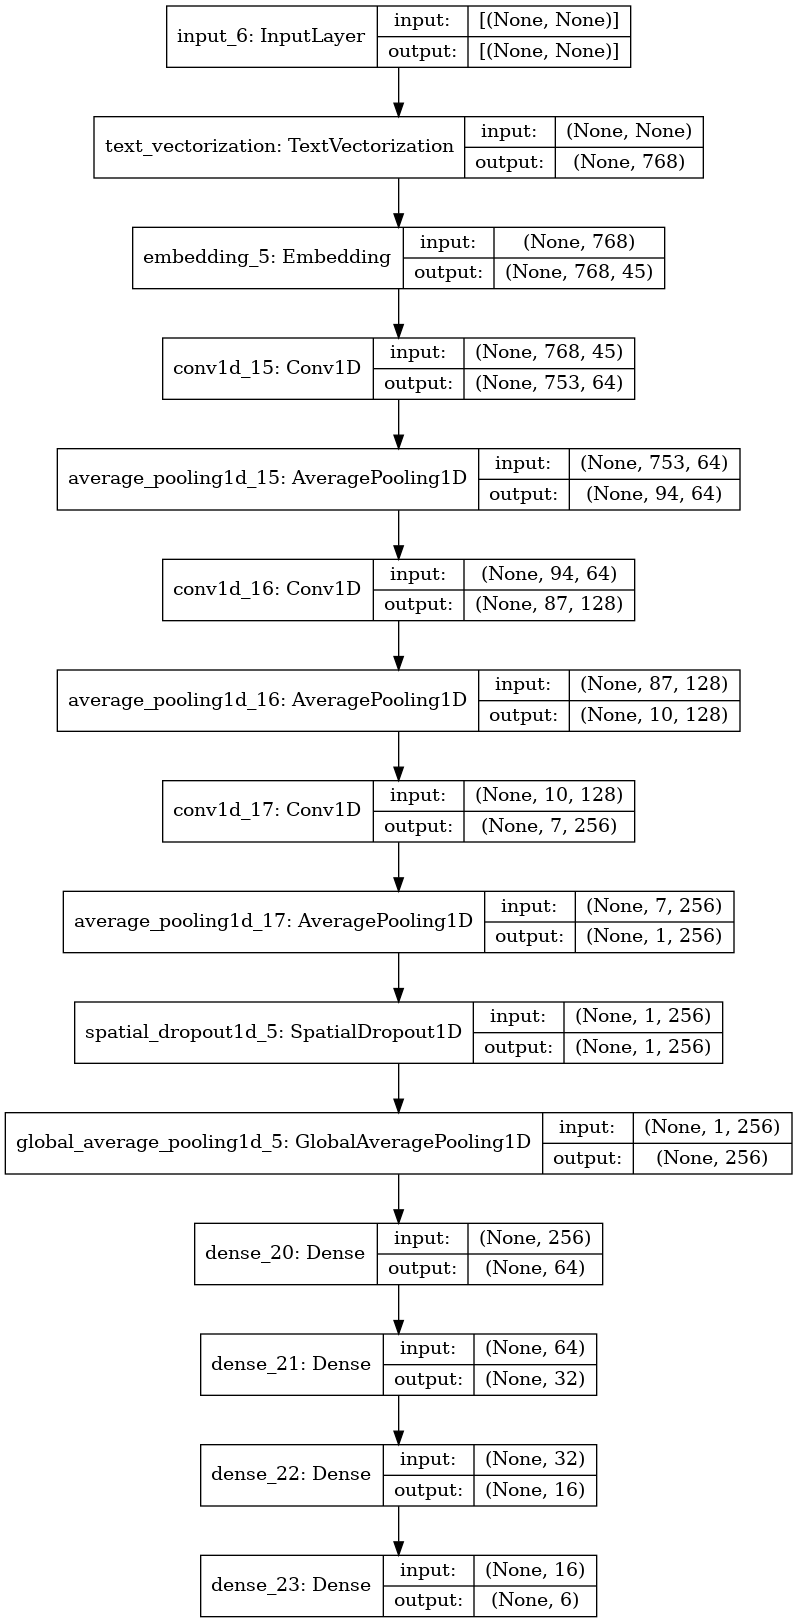

In [63]:
# show the model
keras.utils.plot_model(model, show_shapes=True)

## Training models

In [64]:
# using kfold to train the model
keras.backend.clear_session()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
models = []
rmses = []
for i, (train_indices, valid_indices) in enumerate(kfold.split(train)):
    x_train = train.iloc[train_indices]["text"]
    y_train = train.iloc[train_indices][config.target_columns]
    x_val = train.iloc[valid_indices]["text"]
    y_val = train.iloc[valid_indices][config.target_columns]
    model_path = f"model_{i}.tf"
    model = get_model()
    rmse = tf.keras.metrics.RootMeanSquaredError(name="rmse")
    checkpoint = keras.callbacks.ModelCheckpoint(model_path, monitor="val_rmse", mode="min", save_best_only=True, save_weights_only=True)
    early_stop = keras.callbacks.EarlyStopping(monitor="val_rmse", mode="min", patience=5)
    model.compile(loss="mse", optimizer="adam", metrics=[rmse])
    history = model.fit(
        x_train, y_train, 
        batch_size=config.batch_size, 
        epochs=config.epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint, early_stop]
    )
    model.load_weights(model_path)
    result = model.evaluate(x_val, y_val)
    print("Loss:", result[0], "RMSE:", result[1])
    rmses.append(result[1])
    models.append(model) 
    if not config.use_k_fold:
        break
print(f"Mean RMSE:{np.mean(rmses)}")

Epoch 1/50
49/49 [==============================] - 2s 25ms/step - loss: 4.9532 - rmse: 2.2256 - val_loss: 0.4986 - val_rmse: 0.7061
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 0.5468 - rmse: 0.7395 - val_loss: 0.4316 - val_rmse: 0.6570
Epoch 3/50
49/49 [==============================] - 1s 23ms/step - loss: 0.5009 - rmse: 0.7078 - val_loss: 0.4295 - val_rmse: 0.6554
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 0.4948 - rmse: 0.7035 - val_loss: 0.4268 - val_rmse: 0.6533
Epoch 5/50
49/49 [==============================] - 1s 20ms/step - loss: 0.4737 - rmse: 0.6882 - val_loss: 0.4270 - val_rmse: 0.6535
Epoch 6/50
49/49 [==============================] - 1s 20ms/step - loss: 0.4603 - rmse: 0.6784 - val_loss: 0.4282 - val_rmse: 0.6543
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 0.4515 - rmse: 0.6719 - val_loss: 0.4277 - val_rmse: 0.6540
Epoch 8/50
49/49 [==============================] - 1s 20ms/step - lo

## Submission

In [65]:
# get the results
preds = []
for model in models:
    preds.append(model.predict(test["text"]))
pred = np.mean(preds, axis=0)
submission = pd.DataFrame({
    "text_id": test["text_id"]
})
for i in range(len(config.target_columns)):
    column = config.target_columns[i]
    submission[column] = pred[:, i]
pred = np.mean(preds, axis=0)
submission.to_csv("submission.csv", index=False)

In [66]:
y_real = test[test.columns[3:9]]
y_real

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,2.0,2.0,2.0,2.0,2.0,2.0
1,2.5,2.5,2.5,3.0,2.5,2.0
2,2.0,2.0,2.0,2.0,2.0,2.5
3,2.5,2.0,2.5,2.0,2.0,2.5
4,3.0,2.5,2.0,2.0,2.0,2.5
...,...,...,...,...,...,...
778,3.0,3.5,3.5,4.0,3.5,4.0
779,4.5,4.0,3.5,4.0,3.5,3.5
780,3.5,4.0,4.5,4.0,3.5,3.5
781,4.5,3.5,4.0,4.0,4.0,3.5


In [67]:
y_pred = submission[submission.columns[1:]]
y_pred

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,2.862952,2.755825,2.966659,2.824807,2.724683,2.828537
1,2.791754,2.685455,2.901383,2.758026,2.657459,2.769140
2,2.724274,2.614684,2.832884,2.681591,2.576603,2.700672
3,2.859524,2.754827,2.967978,2.827981,2.729341,2.831291
4,2.636997,2.525620,2.745708,2.589729,2.485467,2.620819
...,...,...,...,...,...,...
778,3.451573,3.358810,3.533695,3.443129,3.380843,3.420422
779,3.274458,3.179759,3.362860,3.260865,3.183205,3.237762
780,3.710618,3.613612,3.778767,3.706603,3.682332,3.697439
781,3.710488,3.614340,3.778901,3.705779,3.682336,3.697980


In [68]:
# calculate the score of our prediction
import math
row = 738
col = 6
total = 0
sum_total = 0
for i in range(col):
    for j in range(row):
        total += (y_real.iloc[j][i] - y_pred.iloc[j][i])**2
    total /= row
    sum_total += math.sqrt(total)
    total = 0
sum_total/= col
sum_total

0.5024750355003083